## 4 文本预处理
文本是一类序列数据，一篇文章可以看作是字符或单词的序列.

预处理通常包括四个步骤：

1. 读入文本
2. 分词
3. 建立字典，将每个词映射到一个唯一的索引（index）
4. 将文本从词的序列转换为索引的序列，方便输入模型

下面简单演示这4个过程

### 4.1 读取文本

In [5]:
import collections
import re

#读取文本函数
def read_time_machine():
    file = "./timemachine.txt"
    with open(file, 'r') as f:
        lines = [re.sub('[^a-z]+', ' ', line.strip().lower()) for line in f]
    return lines

#读取文本,并查看文本有多少行
lines = read_time_machine()
print(len(lines))

3221


### 4.2 分词

In [36]:
#设定分割类型, 默认按照单词进行分词
def tokenize(sentences, token='word'):
    if(token == 'word'):
        return [sentence.split(' ') for sentence in sentences]
    elif(token == 'char'):
        return [list(sentence)for sentence in sentences]
    else:
        print("ERROR: unknow token type" + token)

#分词并查看前6行的分词情况
tokens = tokenize(lines)
tokens[0:6]

[['the', 'time', 'machine', 'by', 'h', 'g', 'wells', ''],
 [''],
 [''],
 [''],
 [''],
 ['i']]

### 4.3 建立字典

为了方便模型处理，我们需要将字符串转换为数字。因此我们需要先构建一个字典（vocabulary），将每个词映射到一个唯一的索引编号。

In [44]:
def count_corpus(sentences):
    tokens = [tk for st in sentences for tk in st]
    #返回一个字典,记录每个词出现的频率
    return collections.Counter(tokens)

class Vocab(object):
    def __init__(self, tokens, min_freq=0, use_special_tokens=False):
        #对分词后tokens进行频率统计
        counter = count_corpus(tokens)
        #将频率统计结果 list, list中的每个元素就是一个tuple,形如('the', 2)
        self.token_freqs = list(counter.items())
        self.idx_to_token = []
        if(use_special_tokens):
            #处理特殊的词
            self.pad, self.bos, self.eos, self.unk = (0, 1, 2, 3)
            self.idx_to_token += ['<pad>', '<bos>', '<eos>', '<unk>']
        else:
            #
            self.unk = 0
            self.idx_to_token += ['<unk>']
        #print(self.idx_to_token,'-------\n')
        
        self.idx_to_token += [token for token, freq in self.token_freqs
                              if( (freq >= min_freq) and (token not in self.idx_to_token) )]
        #print(self.idx_to_token,'-------\n')
        
        #建立可维护的自带索引的字典
        self.token_to_idx = dict()
        for idx, token in enumerate(self.idx_to_token):
            self.token_to_idx[token] = idx
        #print(self.token_to_idx,'-------\n')
        
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if(not isinstance(tokens, (list, tuple))):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if(not isinstance(indices, (list, tuple))):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

In [46]:
#用Time Machine作为语料构建字典
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[0:10])

[('<unk>', 0), ('the', 1), ('time', 2), ('machine', 3), ('by', 4), ('h', 5), ('g', 6), ('wells', 7), ('', 8), ('i', 9)]


将词转换为字典

In [51]:
for i in range(8, 10):
    print('word:', tokens[i])
    #打印第i行单词列表在字典中所对应的索引
    print('indices:', vocab[tokens[i]])
    print('------------')

word: ['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him', '']
indices: [1, 2, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 8]
------------
word: ['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
indices: [21, 22, 23, 24, 25, 17, 26, 27, 28, 29, 30, 31]
------------


### 4.4 用现有工具进行分词 spaCy和NLTK

前面介绍的分词方式非常简单，它至少有以下几个缺点:

1. 标点符号通常可以提供语义信息，但是我们的方法直接将其丢弃了
2. 类似“shouldn't", "doesn't"这样的词会被错误地处理
3. 类似"Mr.", "Dr."这样的词会被错误地处理

简单示例:

In [53]:
text = "Mr. Chen doesn't agree with my suggestion."
lines = re.sub('[^a-z]+', ' ', text.strip().lower())
lines

'mr chen doesn t agree with my suggestion '

spaCy:

In [73]:
import spacy
nlp = spacy.load('en_core_web_sm')
doc = nlp(text)
print([token.text for token in doc])

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

NLTK

In [72]:
from nltk.tokenize import word_tokenize
from nltk import data
print(word_tokenize(text))

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  Searched in:
    - 'C:\\Users\\Administrator/nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - 'D:\\Anaconda3\\nltk_data'
    - 'D:\\Anaconda3\\share\\nltk_data'
    - 'D:\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Administrator\\AppData\\Roaming\\nltk_data'
    - ''
**********************************************************************


### 4.5 课后作业

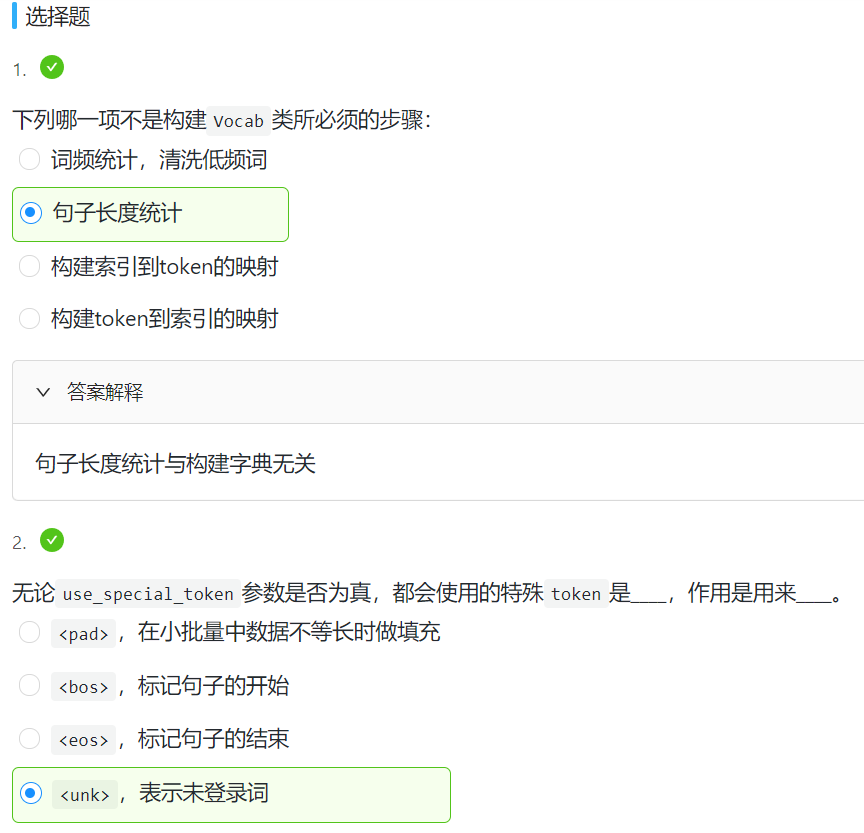